In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import random
from jax.scipy import stats, optimize
from jax.scipy.special import expit, logit
import pandas as pd
import seaborn as sns
sns.set_theme(
    style='white',
    context='talk'
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
red, blue, green = sns.color_palette('Set1', 3)

# Ridge regression

MLE can lead to over-fitting. A common approach to deal with that is **regularization**, and a common regularization approach, which is also the default for logistic regression, is **ridge regression**, or **L2 regression**.
This means that the loss function is a sum of the NLL and a L2 penalty on the parameters, 
$$
\text{loss}(W) = NLL(W) + \frac{\alpha}{2n} {\sum_{j=1}^{m}{w_j}^2}
$$
where $a_j$ are the individual parameters (ProbML ch. 11.3) and $\alpha$ is a weight of the importance of the penalty relative to the fit (NLL). When $\alpha=0$, we are back with NLL.
Notably, ridge regression is equivalent to assuming a gaussian prior on the model parameters and then doing Bayesian inference.

The $\frac{\alpha}{2n}$ is the one used by Scikit-learn in `sklearn.linear_model.LogisticRegression` to facilitate validation and comparison.

Let's try this for logistic regression on the  [Pima diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

In [3]:
# load data
df = pd.read_csv("../data/pima-diabetes.csv")
features = df.columns[:-1].tolist()
X = df[features].values

# scale data
X = (X - X.mean(axis=0)) / X.std(axis=0) # scaling
Y = df['Outcome'].values

# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)

In [4]:
def NLL(W, X, Y, ϵ=1e-15):
    Z = X @ W
    Yhat = expit(Z)
    return -(Y * np.log(Yhat + ϵ) + (1 - Y) * np.log(1 - Yhat - ϵ)).mean()

def accuracy(W, X, Y):
    Z = X @ W
    Yhat = expit(Z)
    return ((Yhat > 0.5) == Y).mean() # fraction of correct predictions. 0.5 is the threshold.

In [26]:
def loss(W, X, Y, α):
    # TODO: your code  here
    return NLL(W, X, Y) + α/(2*X.shape[0]) * (W@W)
    

W = np.ones(X.shape[1])
print(loss(W, X, Y, α=0), loss(W, X, Y, α=1), loss(W, X, Y, α=10))

0.9496371 0.9548454 1.0017204


Let's use `scipy.optimize.minimize` instead of gradient descent; it will be faster. Remember to provide the gradient of the loss function (e.g., using `jax.grad`) for the Jacobian (`jac`) to `minimize`. 
Try to choose `method` that works well.

In [6]:
from scipy.optimize import minimize

In [27]:
def fit_logistic(X, Y, α):
    # TODO: your code here
    def obj_fn(W):
        return loss(W, X, Y, α)
    W0 = np.zeros(X.shape[1])
    opt_res = minimize(obj_fn, W0, jac=jax.grad(obj_fn), method='L-BFGS-B')
    if not opt_res.success:
        raise ValueError("Optimization failed:", opt_res.message)
    return opt_res.x
    

Try to fit the model with different values of $\alpha$ and see how it affects the parameters and the test score.

In [33]:
# Fit the model
# TODO: your code here
print("For α=0:____")
W0 = fit_logistic(X_train, Y_train, α=0)
print("Train NLL:", NLL(W0, X_train, Y_train))
print("Test NLL:", NLL(W0, X_test, Y_test))
print("Train Accuracy:", accuracy(W0, X_train, Y_train))
print("Test Accuracy:", accuracy(W0, X_test, Y_test))

print("For α=100:____")
W1 = fit_logistic(X_train, Y_train, α=100)
print("Train NLL:", NLL(W1, X_train, Y_train))
print("Test NLL:", NLL(W1, X_test, Y_test))
print("Train Accuracy:", accuracy(W1, X_train, Y_train))
print("Test Accuracy:", accuracy(W1, X_test, Y_test))

For α=0:____
Train NLL: 0.53338265
Test NLL: 0.5243072
Train Accuracy: 0.757329
Test Accuracy: 0.74025977
For α=100:____
Train NLL: 0.56414896
Test NLL: 0.56337845
Train Accuracy: 0.7394137
Test Accuracy: 0.73376626


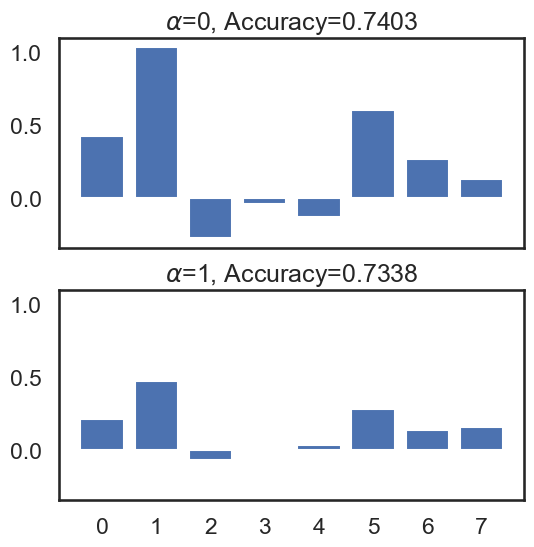

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
axes[0].bar(range(W0.shape[0]), W0)
axes[0].set(title=r'$\alpha$=0, Accuracy={:.4f}'.format(accuracy(W0, X_test, Y_test)), 
            xticks=range(W0.shape[0]))
axes[1].bar(range(W1.shape[0]), W1)
axes[1].set(title=r'$\alpha$=1, Accuracy={:.4f}'.format(accuracy(W1, X_test, Y_test)), 
            xticks=range(W1.shape[0]));

Here's the scikit-learn implementation, for reference.

In [34]:
from sklearn.linear_model import LogisticRegression

In [41]:
reg0 = LogisticRegression(C=np.inf, fit_intercept=False) # C is inverse of λ (alpha)
reg0.fit(X_train, Y_train)
W0 = reg0.coef_.ravel()
reg1 = LogisticRegression(C=0.01, fit_intercept=False) 
reg1.fit(X_train, Y_train)
W1 = reg1.coef_.ravel()
reg0.score(X_test, Y_test), reg1.score(X_test, Y_test)

(0.7402597402597403, 0.7337662337662337)

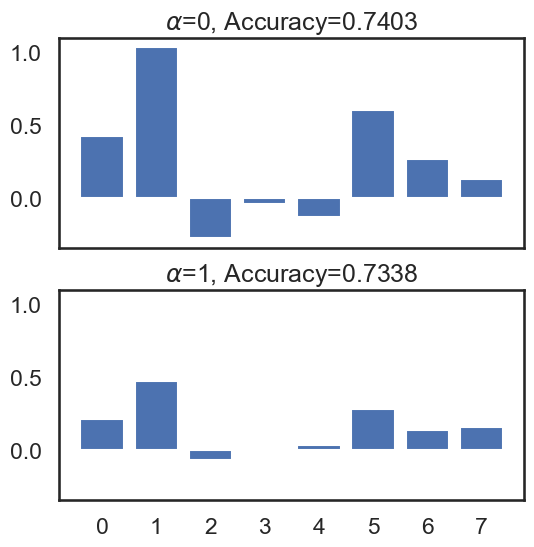

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
axes[0].bar(range(W0.shape[0]), W0)
axes[0].set(title=r'$\alpha$=0, Accuracy={:.4f}'.format(reg0.score(X_test, Y_test)), xticks=range(W0.shape[0]))
axes[1].bar(range(W1.shape[0]), W1)
axes[1].set(title=r'$\alpha$=1, Accuracy={:.4f}'.format(reg1.score(X_test, Y_test)), xticks=range(W1.shape[0]));